In [1302]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import sklearn
from sklearn import datasets
import matplotlib.pyplot as plt
from collections import Counter

# Importing the dataset

In [1303]:
df = pd.read_csv('data.csv')
df.drop('Unnamed: 32', axis=1, inplace=True)

In [1304]:
print(df.head())

         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ...  radius_worst  texture_worst  perimeter_worst  area_wor

# Preprocessing

* Convert into numpy arrays
* Scale features
* Separate labels from features
* Split into train / test sets
* Convert to tensors

## Convert to numpy

In [1305]:
data = df.to_numpy()

## Separate labels from features

In [1306]:
labels = data[:, 1].reshape(569, 1)
train_y, test_y = labels[:284, 0], labels[284:568, 0]
z, r = labels[:284, 0], labels[284:568, 0]
data = data[:, 2:32]

## Convert letter labels into digits

In [1307]:
for i in range(len(train_y)):
        if train_y[i] == 'M':
            train_y[i] = 1
        else:
            train_y[i] = 0

for i in range(len(train_y)):
        if test_y[i] == 'M':
            test_y[i] = 1
        else:
            test_y[i] = 0

## Check out distribution of labels

<BarContainer object of 2 artists>

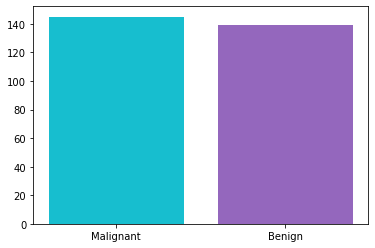

In [1308]:
l = list()
b = list()
for num in train_y:
    if num == 1:
        l.append(num)
    else:
        b.append(num)
labels = ['Malignant', 'Benign']
colors = ['tab:cyan', 'tab:purple']
plt.bar(['Malignant', 'Benign'], [len(l), len(b)], label=labels, color=colors)



# Convert label arrays to tensors

In [1309]:
train_y = torch.from_numpy(train_y.astype(np.float32)).reshape(train_y.shape[0], 1)
test_y = torch.from_numpy(test_y.astype(np.float32)).reshape(test_y.shape[0], 1)

# Plot data as scatterplot, with y-axis being its features summed

Text(0, 0.5, 'Sum of features')

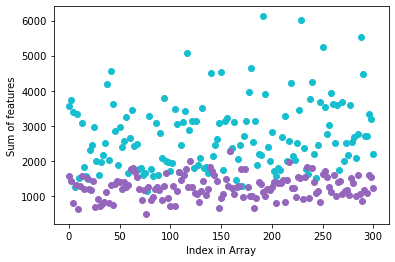

In [1310]:
m = list()
b = list()
for example, label in zip(data[:284], train_y):
    val = np.sum(example)
    if label == 1:
        m.append(val)
    else:
        b.append(val)
x = np.linspace(0, 300, len(m))
colors = ['tab:cyan']
plt.scatter(x, m, color = colors)
x = np.linspace(0, 300, len(b))
colors = ['tab:purple']
plt.scatter(x, b, color=colors)
plt.xlabel('Index in Array')
plt.ylabel('Sum of features')

## Perform feature scaling

In [1311]:
scaler = sklearn.preprocessing.StandardScaler()
data = scaler.fit_transform(data)

## Separate remaining features into train / test sets & convert to tensors

In [1312]:
train_feats = torch.from_numpy(data[:284].astype(np.float32))
test_feats = torch.from_numpy(data[284:568].astype(np.float32))

# Create logistic regression model to following specs:

* The only layers will be the input and output layers
* The two layers are fully connected
* Output is computed with the sigmoid function

In [1313]:
class LogisticRegression(nn.Module):
    def __init__(self, in_dim):
        super(LogisticRegression, self).__init__()
        self.output = nn.Linear(30, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y = self.output(x)
        y = self.sigmoid(y)
        return y

# Initialize model along with its loss function and optimizer

In [1314]:
m = LogisticRegression(30)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(m.parameters(), lr=.01)

# Minimize cost function to find optimal weights

In [1315]:
losses = list()
epochs = 2000
for i in range(epochs):
    output = m(train_feats)
    loss = criterion(output, train_y)
    if (i + 1) % 70 == 0:
        losses.append(loss.item())
    if (i + 1) % 100 == 0 or i == epochs - 1:
        print(f'epoch #{i}, loss: {loss}, weight: {m.output.weight}')
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

epoch #99, loss: 0.08279749006032944, weight: Parameter containing:
tensor([[ 0.3105,  0.6572,  0.5155,  0.5131,  0.2848,  0.1946,  0.4664,  0.2517,
          0.0965, -0.5344,  0.4921, -0.3355,  0.4934,  0.2891,  0.1345, -0.0756,
         -0.2562,  0.2183, -0.3213, -0.4971,  0.4526,  0.6405,  0.2505,  0.3913,
          0.3373,  0.1490,  0.5076,  0.4545,  0.4625,  0.2834]],
       requires_grad=True)
epoch #199, loss: 0.06229056790471077, weight: Parameter containing:
tensor([[ 0.4231,  0.8681,  0.6260,  0.6331,  0.3104,  0.1896,  0.5800,  0.3344,
          0.0513, -0.7373,  0.6309, -0.5048,  0.6189,  0.4354,  0.2673, -0.3699,
         -0.2498,  0.3192, -0.3753, -0.6778,  0.5946,  0.9000,  0.3869,  0.5388,
          0.5086,  0.1956,  0.6479,  0.5857,  0.6697,  0.4492]],
       requires_grad=True)
epoch #299, loss: 0.053167760372161865, weight: Parameter containing:
tensor([[ 0.5033,  0.9968,  0.7050,  0.7215,  0.3108,  0.1597,  0.6643,  0.3809,
          0.0439, -0.9071,  0.7435, -0.654

# Plot loss through all epochs

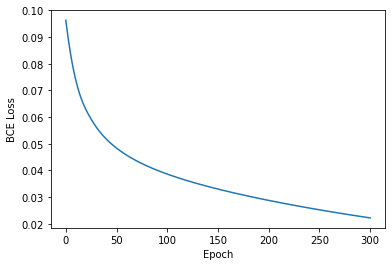

In [1316]:
from scipy.interpolate import make_interp_spline, BSpline
x = np.linspace(0, 300, 28)
y = losses
x_new = np.linspace(x.min(), x.max(), 400)
spl = make_interp_spline(x, y)
y_smooth = spl(x_new)
plt.plot(x_new, y_smooth)
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.show()

# Test accuracy against test set

In [1317]:
with torch.no_grad():
    y_pred=m(test_feats)
    y_pred_class=y_pred.round()
    accuracy=((y_pred_class == test_y).sum()) / 284
    print(f'Accuracy: {round(accuracy.item() * 100, 1)}%')

Accuracy: 96.8%


# Plot decision boundary

284


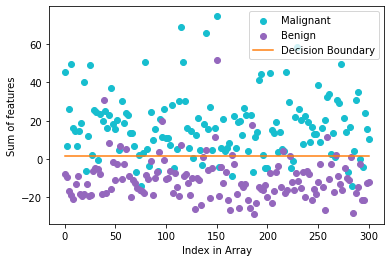

In [1318]:
s = list()
b = list()
for example, label in zip(data[:284], train_y):
    val = np.sum(example)
    if label == 1:
        s.append(val)
    else:
        b.append(val)
x = np.linspace(0, 300, len(s))
print(len(r))
colors = ['tab:cyan']
plt.scatter(x, s, color = colors, label='Malignant')
x = np.linspace(0, 300, len(b))
colors = ['tab:purple']
n = (torch.sum(m.output.weight) - m.output.weight[0] + m.output.weight[0]) / 30
c = m.output.weight[0].detach().numpy()
plt.scatter(x, b, color=colors, label='Benign')
x = np.linspace(0, 300, 30)
plt.plot(x, (n.detach().numpy() + m.output.bias[0].detach().numpy()), color = 'tab:orange', label='Decision Boundary')
plt.xlabel('Index in Array')
plt.ylabel('Sum of features')
plt.legend()